# Introduction

In today's digital era, understanding human emotions through text has become vital for applications ranging from social media analysis to mental health monitoring. This project focuses on developing a machine learning model to classify text into six emotional categories: joy, anger, sadness, fear, surprise, and neutral. While humans naturally understand emotional context and nuances, teaching machines to accurately detect emotions presents unique challenges that require a systematic approach.

My methodology follows a comprehensive pipeline from data preprocessing through model evaluation. I begin with text cleaning using the neattext library to remove noise while preserving emotional content. Through exploratory data analysis, I uncovered key insights about text length distribution and sentiment patterns, which guided my future decisions.

For text vectorization, I employed TF-IDF (Term Frequency-Inverse Document Frequency) to effectively capture word importance within emotion categories. To address class imbalance, I implemented class weighting rather than sampling techniques, ensuring data integrity while maintaining model performance. I experimented with multiple classification models including Logistic Regression, Random Forest, XGBoost, and a Stacking Classifier, optimizing each through careful hyperparameter tuning and cross-validation.

This notebook documents my systematic approach to emotion detection, demonstrating how each decision impacts the model's ability to understand and classify emotional expressions in text.

# <span style='color: #A50000;'>Loading Necessary Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import neattext.functions as nfx
from wordcloud import WordCloud
import emoji

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,recall_score,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from lightgbm import LGBMClassifier as lgb

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pardhasaradhichukka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# <span style='color: #A50000;'>Data Loading</span>


In [2]:
df = pd.read_csv('/Users/pardhasaradhichukka/Desktop/Project Saraswathi/text_em_det/emt_dt.csv')
df = df[['Emotion','Text']]
df.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


# <span style='color: #A50000;'>Intial Data Analysis</span>

In [3]:
df['Text'][3]

" Such an eye ! The true hazel eye-and so brilliant ! Regular features , open countenance , with a complexion , Oh ! What a bloom of full health , and such a pretty height and size ; such a firm and upright figure ! There is health , not merely in her bloom , but in her air , her head , her glance . One hears sometimes of a child being ' the picture of health ' ; now , she always gives me the idea of being the complete picture of grown-up health . She is loveliness itself . "

In [4]:
df.shape

(34792, 2)

In [5]:
df.isnull().sum()

Emotion    0
Text       0
dtype: int64

In [6]:
df.duplicated().sum()

3630

In [7]:
df.dtypes

Emotion    object
Text       object
dtype: object

In [8]:
df['Emotion'].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

# <span style='color: #A50000;'>Exploratory Data Analysis</span>


## <span style='color: #FF6F61;'>Data Distribution</span>

<Axes: xlabel='Emotion', ylabel='count'>

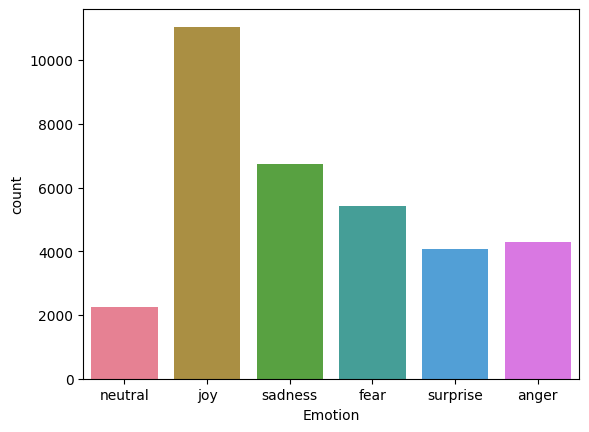

In [9]:
req_emt = ['neutral','joy','sadness','anger','surprise','fear']
df = df[df['Emotion'].isin(req_emt)]
sns.countplot(x='Emotion', data=df, palette='husl',hue='Emotion', legend=False)

## <span style='color: #FF6F61;'>Text Length Analysis</span>

<Axes: xlabel='Emotion'>

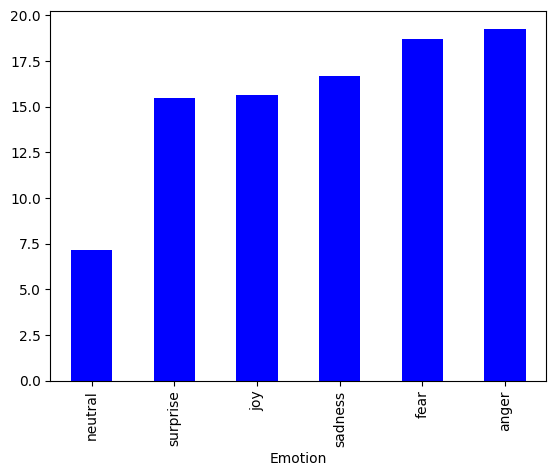

In [10]:
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
df.groupby('Emotion')['word_count'].mean().sort_values().plot(kind='bar', color='blue')

<Axes: xlabel='Emotion'>

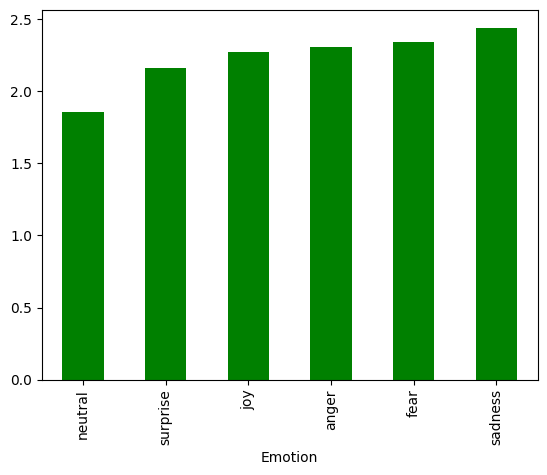

In [11]:
df['sent_count'] = df['Text'].apply(lambda x: len(x.split('.')))
df.groupby('Emotion')['sent_count'].mean().sort_values().plot(kind='bar', color='green')

## <span style='color: #FF6F61;'>Overall Sentiment Analysis</span>

<Axes: xlabel='Emotion'>

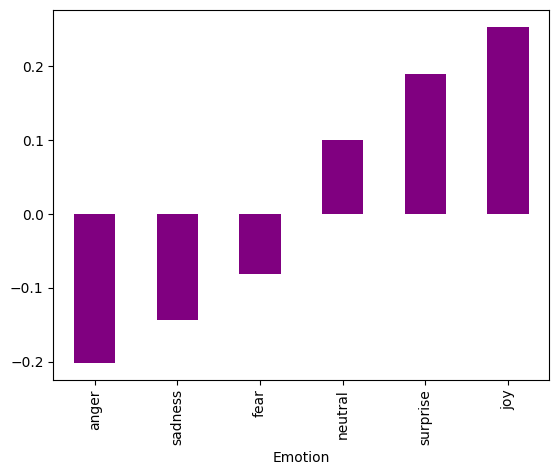

In [12]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']

df['sentiment_score'] = df['Text'].apply(analyze_sentiment)
df.groupby('Emotion')['sentiment_score'].mean().sort_values().plot(kind='bar', color='purple')

In [13]:
df.head()

,Emotion,Text,word_count,sent_count,sentiment_score
0,neutral,Why ?,2,1,0.0000
1,joy,Sage Act upgrade on my to do list for tommorow.,10,2,0.0000
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,20,1,-0.6981
3,joy,Such an eye ! The true hazel eye-and so brill...,102,4,0.7965
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,22,4,-0.4753


# <span style='color: #A50000;'>Data Preprocessing</span>

##  <span style='color: #FF6F61;'>Text Cleaning</span>

### <span style='color: #FFB6B0;'>Removing Noise</span>

In [14]:
df['clean_txt'] = df['Text'].apply(nfx.remove_userhandles)
df['clean_txt'] = df['clean_txt'].apply(emoji.demojize)
df['clean_txt'] = df['clean_txt'].apply(nfx.remove_hashtags)
df['clean_txt'] = df['clean_txt'].apply(nfx.remove_stopwords)
df['clean_txt'] = df['clean_txt'].apply(nfx.remove_punctuations)
df['clean_txt'] = df['clean_txt'].apply(nfx.remove_urls)
df['clean_txt'] = df['clean_txt'].str.lower()


In [15]:
df[['Text','clean_txt']][0:10]

,Text,clean_txt
0,Why ?,
1,Sage Act upgrade on my to do list for tommorow.,sage act upgrade list tommorow
2,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,way homegirl baby funeral man hate funerals sh...
3,Such an eye ! The true hazel eye-and so brill...,eye true hazel eyeand brilliant regular feat...
4,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe hugggzzz u babe naamazed nga ako e b...
5,I'm expecting an extremely important phonecall...,im expecting extremely important phonecall minute
6,.Couldnt wait to see them live. If missing th...,couldnt wait live missing nh7 wasnt painful en...
7,maken Tip 2: Stop op een moment dat je het hel...,maken tip 2: stop op een moment dat je het hel...
8,En dan krijg je ff een cadeautje van een tweep...,en dan krijg je ff een cadeautje van een tweep
9,@1116am Drummer Boy bij op verzoek van @BiemO...,drummer boy bij op verzoek van : welke uitvoe...


### <span style='color: #FFB6B0;'>Keyword Extraction</span>

In [16]:
df.head()

,Emotion,Text,word_count,sent_count,sentiment_score,clean_txt
0,neutral,Why ?,2,1,0.0000,
1,joy,Sage Act upgrade on my to do list for tommorow.,10,2,0.0000,sage act upgrade list tommorow
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,20,1,-0.6981,way homegirl baby funeral man hate funerals sh...
3,joy,Such an eye ! The true hazel eye-and so brill...,102,4,0.7965,eye true hazel eyeand brilliant regular feat...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,22,4,-0.4753,ugh babe hugggzzz u babe naamazed nga ako e b...


In [17]:
# Combine all text into a single list of words
all_words = " ".join(df['clean_txt']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the total number of unique words
vocabulary_size = len(word_counts)

print(f"Estimated vocabulary size: {vocabulary_size}")

Estimated vocabulary size: 33848


In [18]:
def extract_keywords_tfidf(text_list, num=30):
    vectorizer = TfidfVectorizer()

    tfidf_matrix = vectorizer.fit_transform(text_list)

    feature_names = vectorizer.get_feature_names_out()

    # Calculate the average TF-IDF score for each word across all documents
    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
    
    # Create a dictionary of words and their average TF-IDF scores
    word_tfidf_dict = dict(zip(feature_names, avg_tfidf_scores))
    
    # Sort the words by their TF-IDF scores in descending order
    sorted_word_tfidf = sorted(word_tfidf_dict.items(), key=lambda x: x[1], reverse=True)
    
    return dict(sorted_word_tfidf[:num])


joy_list = df[df['Emotion'] == 'joy']['clean_txt'].tolist()
joy_keywords = extract_keywords_tfidf(joy_list)

sad_list = df[df['Emotion'] == 'sadness']['clean_txt'].tolist()
sad_keywords = extract_keywords_tfidf(sad_list)

neutral_list = df[df['Emotion'] == 'neutral']['clean_txt'].tolist()
neutral_keywords = extract_keywords_tfidf(neutral_list)

fear_list = df[df['Emotion'] == 'fear']['clean_txt'].tolist()
fear_keywords = extract_keywords_tfidf(fear_list)

surprise_list = df[df['Emotion'] == 'surprise']['clean_txt'].tolist()
surprise_keywords = extract_keywords_tfidf(surprise_list)

anger_list = df[df['Emotion'] == 'anger']['clean_txt'].tolist()
anger_keywords = extract_keywords_tfidf(anger_list)

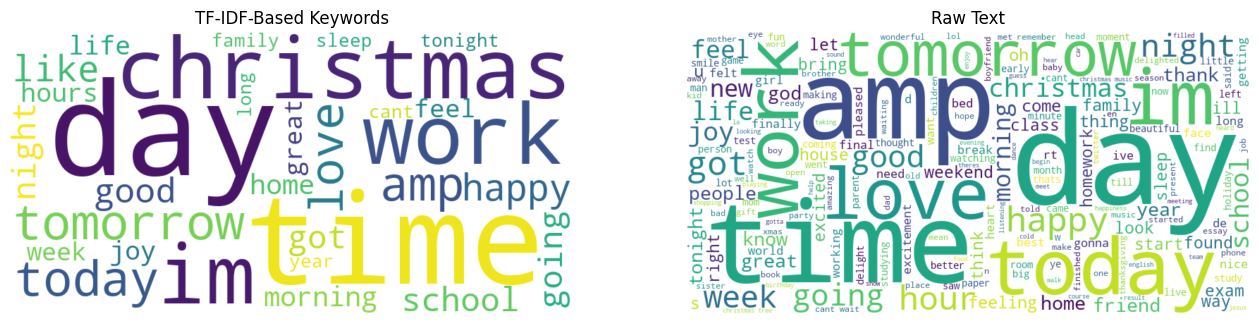

In [19]:
joy_text = ' '.join(df[df['Emotion'] == 'joy']['clean_txt'].tolist())

# WordCloud for TF-IDF
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(joy_keywords)

# WordCloud for raw text
wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(joy_text)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot TF-IDF WordCloud
axes[0].imshow(wordcloud_tfidf, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("TF-IDF-Based Keywords")

# Plot Raw Text WordCloud
axes[1].imshow(wordcloud_raw, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Raw Text")

plt.show()

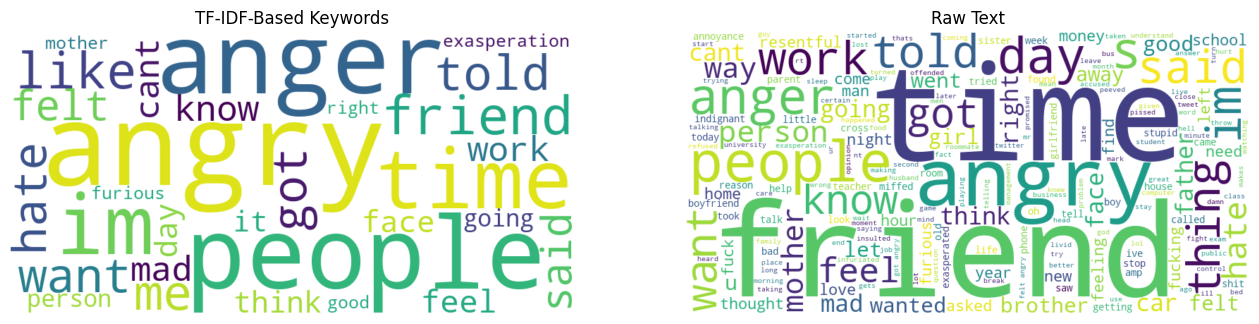

In [20]:
anger_text = ' '.join(df[df['Emotion'] == 'anger']['clean_txt'].tolist())

wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(anger_keywords)

wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(anger_text)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(wordcloud_tfidf, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("TF-IDF-Based Keywords")

axes[1].imshow(wordcloud_raw, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Raw Text")

plt.show()

# <span style='color: #A50000;'>Machine Learning</span>

## <span style='color: #FF6F61;'>Splitting Data</span>

In [21]:
df.head()

,Emotion,Text,word_count,sent_count,sentiment_score,clean_txt
0,neutral,Why ?,2,1,0.0000,
1,joy,Sage Act upgrade on my to do list for tommorow.,10,2,0.0000,sage act upgrade list tommorow
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,20,1,-0.6981,way homegirl baby funeral man hate funerals sh...
3,joy,Such an eye ! The true hazel eye-and so brill...,102,4,0.7965,eye true hazel eyeand brilliant regular feat...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,22,4,-0.4753,ugh babe hugggzzz u babe naamazed nga ako e b...


In [22]:
X = df['clean_txt']
y = df['Emotion']  

# Split into training and temporary set (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=54, stratify=y)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=54, stratify=y_temp)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 23653 samples
Validation set: 5068 samples
Test set: 5069 samples


## <span style='color:  #FF6F61;'>Handling Class Imbalance</span>

In [23]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

print("Class weights:", class_weight_dict)

Class weights: {'anger': 1.3105607269503545, 'fear': 1.040973505853358, 'joy': 0.5098508363510951, 'neutral': 2.498204478242501, 'sadness': 0.8378675168260715, 'surprise': 1.386622112791652}


## <span style='color:  #FF6F61;'>Vectorize the Text Data</span>

In [24]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the validation and test data
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

## <span style='color:  #FF6F61;'>Model Training</span> 

### <span style='color:  #FFB6B0;'>Logistic Regression</span>

In [25]:
model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on validation set
y_val_pred_LR = model.predict(X_val_tfidf)
print("Validation Set Metrics:")
print(classification_report(y_val, y_val_pred_LR))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_LR))
print("\n")


# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_LR))
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Set Metrics:
              precision    recall  f1-score   support

       anger       0.57      0.60      0.58       645
        fear       0.68      0.63      0.66       811
         joy       0.73      0.59      0.65      1656
     neutral       0.44      0.80      0.56       338
     sadness       0.62      0.56      0.59      1008
    surprise       0.43      0.51      0.47       610

    accuracy                           0.60      5068
   macro avg       0.58      0.62      0.59      5068
weighted avg       0.62      0.60      0.60      5068

Confusion Matrix:
[[388  41  53  50  63  50]
 [ 65 514  58  42  70  62]
 [ 94  96 984 141 138 203]
 [ 14   9  20 269  13  13]
 [ 87  60 124  76 569  92]
 [ 37  36 117  38  69 313]]


Validation Accuracy: 0.5992501973164956


### <span style='color:  #FFB6B0;'>Random Forest</span>

In [26]:
# Train Random Forest without class weighting
rf_model = RandomForestClassifier(random_state=54)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate on validation set
y_val_pred_rf = rf_model.predict(X_val_tfidf)
print("Random Forest (No Class Weighting) Validation Metrics:")
print(classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))
print("\n")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))

# # Train Random Forest with class weighting
# rf_model_weighted = RandomForestClassifier(class_weight='balanced', random_state=54)
# rf_model_weighted.fit(X_train_tfidf, y_train)

# # Evaluate on validation set
# y_val_pred_rf_weighted = rf_model_weighted.predict(X_val_tfidf)
# print("Random Forest (With Class Weighting) Validation Metrics:")
# print(classification_report(y_val, y_val_pred_rf_weighted))
# print("Confusion Matrix:")
# print(confusion_matrix(y_val, y_val_pred_rf_weighted))
# print("\n")
# print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf_weighted))


Random Forest (No Class Weighting) Validation Metrics:
              precision    recall  f1-score   support

       anger       0.70      0.50      0.58       645
        fear       0.80      0.64      0.71       811
         joy       0.57      0.83      0.67      1656
     neutral       0.55      0.73      0.63       338
     sadness       0.62      0.51      0.56      1008
    surprise       0.67      0.31      0.43       610

    accuracy                           0.62      5068
   macro avg       0.65      0.59      0.60      5068
weighted avg       0.64      0.62      0.61      5068

Confusion Matrix:
[[ 321   18  185   29   82   10]
 [  23  515  177   25   60   11]
 [  37   41 1368   83   90   37]
 [   7    5   54  247   19    6]
 [  51   41  335   37  513   31]
 [  21   23  292   26   57  191]]


Validation Accuracy: 0.6225335438042621


### <span style='color:  #FFB6B0;'>XGBoost</span>

In [27]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=54)
xgb_model = xgb.XGBClassifier(
    n_estimators=200,  # Number of boosting rounds
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum depth of a tree
    objective='multi:softmax',  # Multi-class classification
    eval_metric='mlogloss',  # Evaluation metric
    use_label_encoder=False,  # Avoid warnings
    random_state=54,
    n_jobs=-1  # Use all available CPU cores
)
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Evaluate on validation set
y_val_encoded = label_encoder.transform(y_val)
y_val_pred_xgb = xgb_model.predict(X_val_tfidf)
print("XGBoost (No Class Weighting) Validation Metrics:")
print(classification_report(y_val_encoded, y_val_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_val_encoded, y_val_pred_xgb))
print("\n")
print("Validation Accuracy:", accuracy_score(y_val_encoded, y_val_pred_xgb))

/Users/pardhasaradhichukka/Desktop/Project Saraswathi/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:23:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (No Class Weighting) Validation Metrics:
              precision    recall  f1-score   support

           0       0.84      0.39      0.53       645
           1       0.88      0.47      0.61       811
           2       0.46      0.93      0.61      1656
           3       0.76      0.27      0.39       338
           4       0.73      0.44      0.55      1008
           5       0.68      0.30      0.42       610

    accuracy                           0.57      5068
   macro avg       0.73      0.47      0.52      5068
weighted avg       0.68      0.57      0.55      5068

Confusion Matrix:
[[ 251    6  338    4   42    4]
 [  15  379  369    2   32   14]
 [  11   14 1535   15   42   39]
 [   0    1  232   90   12    3]
 [  14   17  495    6  448   28]
 [   7   13  368    1   36  185]]


Validation Accuracy: 0.5698500394632992


### <span style='color:  #FFB6B0;'>Stacking Model</span>

In [28]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=54)),
    ('xgb', xgb.XGBClassifier(n_estimators=200, random_state=54))
]

# Initialize Stacking Classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5  # Cross-validation folds
)

# Train the model
stacking_model.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=54)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_po...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=54, ...))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [29]:
stacking_model_pred = stacking_model.predict(X_val_tfidf)
print("Stacking Validation Metrics:")
print(classification_report(y_val, stacking_model_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, stacking_model_pred))
print("\n")
print("Validation Accuracy:", accuracy_score(y_val, stacking_model_pred))

Stacking Validation Metrics:
              precision    recall  f1-score   support

       anger       0.69      0.52      0.59       645
        fear       0.79      0.65      0.71       811
         joy       0.58      0.83      0.68      1656
     neutral       0.69      0.66      0.68       338
     sadness       0.63      0.56      0.59      1008
    surprise       0.66      0.35      0.46       610

    accuracy                           0.64      5068
   macro avg       0.67      0.59      0.62      5068
weighted avg       0.65      0.64      0.63      5068

Confusion Matrix:
[[ 334   18  182   16   81   14]
 [  27  528  170   12   62   12]
 [  38   49 1371   43  104   51]
 [   9    6   73  223   21    6]
 [  59   44  297   20  561   27]
 [  17   26  281    8   62  216]]


Validation Accuracy: 0.6379242304656669


## <span style='color:  #FF6F61;'>Hyperparameter Tuning</span>

### <span style='color:  #FFB6B0;'>Logistic Regression</span>

In [30]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'multi_class': ['ovr', 'multinomial'],
    'solver': ['saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(class_weight=class_weight_dict, max_iter=1000), param_grid, cv=3, scoring='f1_macro')

# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_tfidf)
print("Test Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

/Users/pardhasaradhichukka/Desktop/Project Saraswathi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/pardhasaradhichukka/Desktop/Project Saraswathi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/pardhasaradhichukka/Desktop/Project Saraswathi/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this 

Best Parameters: {'C': 10, 'multi_class': 'ovr', 'solver': 'saga'}
Test Accuracy: 0.5964877663772692
Classification Report:
               precision    recall  f1-score   support

       anger       0.58      0.59      0.58       645
        fear       0.67      0.65      0.66       811
         joy       0.70      0.59      0.64      1656
     neutral       0.50      0.76      0.60       338
     sadness       0.60      0.57      0.58      1008
    surprise       0.41      0.50      0.45       610

    accuracy                           0.60      5068
   macro avg       0.58      0.61      0.59      5068
weighted avg       0.61      0.60      0.60      5068



### <span style='color:  #FFB6B0;'>Random Forest</span>

In [31]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=54), param_grid_rf, cv=3, scoring='f1_macro')
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=54),
    param_grid_rf,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1  # Use all available cores
)
grid_search_rf.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Evaluate best model on validation set
y_val_pred_rf_best = grid_search_rf.predict(X_val_tfidf)
print("Random Forest (Best Model) Validation Metrics:")
print(classification_report(y_val, y_val_pred_rf_best))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf_best))
print("\n")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf_best))

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest (Best Model) Validation Metrics:
              precision    recall  f1-score   support

       anger       0.71      0.48      0.57       645
        fear       0.79      0.62      0.69       811
         joy       0.56      0.83      0.67      1656
     neutral       0.56      0.71      0.63       338
     sadness       0.65      0.52      0.58      1008
    surprise       0.65      0.31      0.42       610

    accuracy                           0.62      5068
   macro avg       0.65      0.58      0.59      5068
weighted avg       0.64      0.62      0.61      5068

Confusion Matrix:
[[ 309   19  201   30   74   12]
 [  24  502  188   25   56   16]
 [  30   43 1379   79   84   41]
 [   6    8   60  241   18    5]
 [  49   37  335   36  525   26]
 [  18   26  302   20   55  189]]


Validation Accuracy: 0.6205603788476717


### <span style='color:  #FFB6B0;'>Stacking Model</span>

Dont run this, computationally expensive

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=200, random_state=42))
    # ('lgb', lgb(n_estimators=5, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5  # Cross-validation folds
)

pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Handle sparse matrices
    ('stacking', stacking_model)
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)


st_best_model = grid_search.best_estimator_

st_best_model.fit(X_train_tfidf, y_train)

accuracy = st_best_model.score(X_test_tfidf, y_test)
print(f"Best Model Accuracy with LogisticRegression as Final Estimator: {accuracy}")


stack_best_model_pred = st_best_model.predict(X_val_tfidf)
print("Random Forest (Best Model) Validation Metrics:")
print(classification_report(y_val, stack_best_model_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, stack_best_model_pred))
print("\n")
print("Validation Accuracy:", accuracy_score(y_val, stack_best_model_pred))

## <span style='color:  #FF6F61;'>Model Evaluation</span> 

In [32]:
# Predict on test set
y_test_pred_LR = best_model.predict(X_test_tfidf)

y_test_pred_RF = grid_search_rf.predict(X_test_tfidf)

y_test_pred_XG = xgb_model.predict(X_test_tfidf)
y_val_encoded = label_encoder.transform(y_test)

stack_test_pred = stacking_model.predict(X_test_tfidf)

# Evaluate the model
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "StackModel"],
    "Accuracy": [
        accuracy_score(y_test, y_test_pred_LR),
        accuracy_score(y_test, y_test_pred_RF),
        accuracy_score(y_val_encoded, y_test_pred_XG),
        accuracy_score(y_test, stack_test_pred),

    ],
    "Precision (Macro)": [
        precision_score(y_test, y_test_pred_LR, average='macro'),
        precision_score(y_test, y_test_pred_RF, average='macro'),
        precision_score(y_val_encoded, y_test_pred_XG, average='macro'),
        precision_score(y_test, stack_test_pred, average='macro'),
    ],
    "Recall (Macro)": [
        recall_score(y_test, y_test_pred_LR, average='macro'),
        recall_score(y_test, y_test_pred_RF, average='macro'),
        recall_score(y_val_encoded, y_test_pred_XG, average='macro'),
        recall_score(y_test, stack_test_pred, average='macro'),
    ],
    "F1-Score (Macro)": [
        f1_score(y_test, y_test_pred_LR, average='macro'),
        f1_score(y_test, y_test_pred_RF, average='macro'),
        f1_score(y_val_encoded, y_test_pred_XG, average='macro'),
        f1_score(y_test, stack_test_pred, average='macro'),
    ]
}


results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Logistic Regression,0.601105,0.578027,0.622342,0.590362
1,Random Forest,0.625370,0.654090,0.588415,0.598847
2,XGBoost,0.569343,0.723590,0.471436,0.526690
3,StackModel,0.640955,0.667072,0.602542,0.622589


# <span style='color: #A50000;'>Final Test on Random Samples Of ML</span>

- Neutral: "I don't have any particular feelings about that."
- Sadness: "I feel a deep sorrow knowing that I've lost something precious."
- Joy: "I am over the moon with happiness and excitement."
- Anger: "I am furious that things didn't go as planned."
- Surprise: "Wow, I didn't expect to see you here!"
- Fear: "I am terrified of what might happen next."

In [39]:
# test_sentences = "After months of being apart, we finally managed to coordinate a reunion. When I walked into the café and saw all my friends waiting with huge smiles, I was overwhelmed with joy to be surrounded by people I love."
test_sentences = "I don't have any particular feelings about that."
  


clean_test_sentence = nfx.remove_userhandles(test_sentences)
clean_test_sentence = nfx.remove_hashtags(clean_test_sentence)
clean_test_sentence = nfx.remove_stopwords(clean_test_sentence)
clean_test_sentence = nfx.remove_punctuations(clean_test_sentence)
clean_test_sentence = nfx.remove_urls(clean_test_sentence)

sentence_tfidf = tfidf.transform([clean_test_sentence])

# predicted_emotion = best_model.predict(sentence_tfidf)[0]
# predicted_emotion = grid_search_rf.predict(sentence_tfidf)[0]
predicted_emotion = stacking_model.predict(sentence_tfidf)[0]

print(f"Sentence: {test_sentences}")
print(f"Predicted Emotion: {predicted_emotion}")

Sentence: I don't have any particular feelings about that.
Predicted Emotion: neutral
